In [250]:
import numpy as np
import scipy.stats
from os import listdir
import random
import matplotlib.pyplot as plt
from itertools import product, combinations, zip_longest
import cvxpy as cp
from collections import namedtuple, Counter

# Pull genotypes for a chromosome
data_dir = '../split_gen_ihart_23andme'
chroms = [str(i) for i in range(1, 23)] + ['X', 'Y']
ped_file = '../data/160826.ped'

In [252]:
# 0 = 0/0
# 1 = 0/1
# 2 = 1/1
# 3 = ./.
# 4 = -/0 (hemizygous ref)
# 5 = -/1 (hemizygous alt)
# 6 = -/- (double deletion)

errors = [(0, 1), (0, 2), (0, 3), 
          (1, 0), (1, 2), (1, 3), 
          (2, 0), (2, 1), (2, 3), 
          (4, 1), (4, 2), (4, 3),
          (5, 0), (5, 1), (5, 3),
          (6, 0), (6, 1), (6, 2)]
error_to_index = dict([(x, i) for i, x in enumerate(errors)])
print('errors', len(errors))


errors 18


In [297]:
mendelian_trios = {
    (0, 0, 0), 
    (0, 1, 0), (0, 1, 1),
    (0, 2, 1),
    (1, 0, 0), (1, 0, 1),
    (1, 1, 0), (1, 1, 1), (1, 1, 2),
    (1, 2, 1), (1, 2, 2),
    (2, 0, 1),
    (2, 1, 1), (2, 1, 2),
    (2, 2, 2)
}

mendelian_check = lambda x: x in mendelian_trios
autosome_gen_to_error = dict([(e, e) for e in errors if e[0] <= 2])

In [299]:
mendelian_trios_X_F = {
    (0, 0, 0), 
    (0, 2, 1),
    (1, 0, 0), (1, 0, 1),
    (1, 2, 1), (1, 2, 2),
    (2, 0, 1),
    (2, 2, 2)
}
mendelian_trios_X_M = {
    (0, 0, 0), 
    (0, 2, 0),
    (1, 0, 0), (1, 0, 2),
    (1, 2, 0), (1, 2, 2),
    (2, 0, 2),
    (2, 2, 2)
}

mendelian_X_F_check = lambda x: x in mendelian_trios_X_F
mendelian_X_M_check = lambda x: x in mendelian_trios_X_M

X_gen_to_error_F = autosome_gen_to_error
X_gen_to_error_M = {(0, 1): (4, 1), (0, 2): (4, 2), (0, 3): (4, 3),
                    (2, 0): (5, 0), (2, 1): (5, 1), (2, 3): (5, 3)}

In [300]:
mendelian_trios_Y_F = {
    (3, 0, 3), 
    (3, 2, 3)
}
mendelian_trios_Y_M = {
    (3, 0, 0), 
    (3, 2, 2),
}
mendelian_Y_F_check = lambda x: x in mendelian_trios_Y_F
mendelian_Y_M_check = lambda x: x in mendelian_trios_Y_M

Y_gen_to_error = {(3, 0): (6, 0), (3, 1): (6, 1), (3, 2): (6, 2),
                  (0, 1): (4, 1), (0, 2): (4, 2), (0, 3): (4, 3),
                  (2, 0): (5, 0), (2, 1): (5, 1), (2, 3): (5, 3)}

# Pull Data

In [257]:
# pull sex from ped file
sample_id_to_sex = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, f_id, m_id = pieces[0:4]

        sample_id_to_sex[m_id] = '2'
        sample_id_to_sex[f_id] = '1'
        if len(pieces) > 4:
            sample_id_to_sex[child_id] = pieces[4]
            
print('sex for inds: %d' % len(sample_id_to_sex))



sex for inds: 5073


In [305]:
family_chrom_to_counts = dict()
family_to_inds = dict()
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    chrom_length = chrom_lengths[chrom]
    with open('%s/chr.%s.famgen.counts.txt' % (data_dir, chrom), 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            famkey, inds = pieces[:2]
            inds = inds.split('.')
            m = len(inds)
            
            if m <= 7:
                if famkey not in family_to_inds:
                    family_to_inds[famkey] = inds
                else:
                    assert family_to_inds[famkey] == inds

                counts = np.zeros((4,)*m, dtype=int)
                for g, c in zip(product([0, 1, 2, 3], repeat=m), pieces[2:]):
                    counts[g] = int(c)
                
                #if chrom != 'Y':
                #    counts[(0,)*m] += (chrom_length - np.sum(counts)) 
                #else:
                #    counts[tuple(0 if sample_id_to_sex[ind]=='1' else 3 if sample_id_to_sex[ind]=='2' else None for ind in inds)] += (chrom_length - np.sum(counts)) 

                family_chrom_to_counts[(famkey, chrom)] = counts
            

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 X Y 

In [306]:
print('Families of each size', Counter([len(inds) for fkey, inds in family_to_inds.items()]))


Families of each size Counter({4: 444, 5: 352, 6: 57, 3: 18, 7: 9})


In [307]:
famkeys = sorted(set([x[0] for x in family_chrom_to_counts.keys()]))
print('Families', len(famkeys))

Families 880


# Poisson Regression

In [308]:
def get_mendelian(ind_is_mendelian):
    
    # differentiate mendelian and non-mendelian famgens
    m = len(ind_is_mendelian)
    is_mendelian = np.ones((4,)*m, dtype=bool)
    for famgen in product([0, 1, 2, 3], repeat=m):
        is_mend = True
        for j in range(2, m):
            if not ind_is_mendelian[j](tuple(famgen[x] for x in [0, 1, j])):
                is_mend = False
        is_mendelian[famgen] = is_mend
    return is_mendelian


In [309]:
def get_error_to_famgen_pairs(is_mendelian, ind_gen_switch_to_error):
    nonmendelian_famgens = list(zip(*np.where(~is_mendelian)))
    #print('Mendelian', np.sum(is_mendelian), 'Nonmendelian', len(nonmendelian_famgens))

    error_to_fg_pairs = dict([(e, []) for e in errors])
    for nmfg in nonmendelian_famgens:
        for j in range(m):
            for i in range(4):
                mfg = tuple(i if k==j else nmfg[k] for k in range(m))
                if is_mendelian[mfg]:
                    error = ind_gen_switch_to_error[j][(mfg[j], nmfg[j])]
                    error_to_fg_pairs[error].append((nmfg, mfg))
        
    return nonmendelian_famgens, error_to_fg_pairs

In [310]:
def build_family_chrom_X_and_y(counts, nonmendelian_famgens, error_to_fg_pairs):
    m = len(counts.shape)
    nm_famgen_to_index = dict([(x, i) for i, x in enumerate(nonmendelian_famgens)])
    
    X = np.zeros((len(nonmendelian_famgens), len(errors)))
    
    for error, fg_pairs in error_to_fg_pairs.items():
        error_index = error_to_index[error]
        for famgen, neighbor in fg_pairs: # nmfg, mfg
            famgen_index = nm_famgen_to_index[famgen]
            
            if counts[neighbor]>0:
                X[famgen_index, error_index] += counts[neighbor]
                
    y = np.asarray([counts[x] for x in nonmendelian_famgens])
    
    return X, y

In [311]:
chrom_Xs, chrom_ys = [[] for chrom in chroms], [[] for chrom in chroms]

c = 0
for famkey in famkeys:
    inds = family_to_inds[famkey]
    m = len(inds)
    
    is_mendelian = get_mendelian([None, None] + ([mendelian_check]*(m-2)))

    nonmendelian_famgens, error_to_fg_pairs = get_error_to_famgen_pairs(is_mendelian, [autosome_gen_to_error]*m)
    
    for i, chrom in enumerate(chroms):
        if chrom != 'X' and chrom != 'Y':
            counts = family_chrom_to_counts[(famkey, chrom)]
            X, y = build_family_chrom_X_and_y(counts, nonmendelian_famgens, error_to_fg_pairs)
    
            chrom_Xs[i].append(X)
            chrom_ys[i].append(y)
            
        elif chrom == 'X':
            # X has its own rules for mendelian/non-mendelian
            ind_is_mendelian = [None, None] + [mendelian_X_F_check if sample_id_to_sex[ind] == '2' else mendelian_X_M_check if sample_id_to_sex[ind] == '1' else None for ind in inds[2:]]
            X_is_mendelian = get_mendelian(ind_is_mendelian)
            ind_gen_switch_to_error = [X_gen_to_error_F if sample_id_to_sex[ind] == '2' else X_gen_to_error_M if sample_id_to_sex[ind] == '1' else None for ind in inds]
            X_nonmendelian_famgens, X_error_to_fg_pairs = get_error_to_famgen_pairs(X_is_mendelian, ind_gen_switch_to_error)

            counts = family_chrom_to_counts[(famkey, chrom)]
            X, y = build_family_chrom_X_and_y(counts, X_nonmendelian_famgens, X_error_to_fg_pairs)

            chrom_Xs[i].append(X)
            chrom_ys[i].append(y)
            
        elif chrom == 'Y':
            # Y has its own rules for mendelian/non-mendelian
            ind_is_mendelian = [None, None] + [mendelian_Y_F_check if sample_id_to_sex[ind] == '2' else mendelian_Y_M_check if sample_id_to_sex[ind] == '1' else None for ind in inds[2:]]
            Y_is_mendelian = get_mendelian(ind_is_mendelian)
            Y_nonmendelian_famgens, Y_error_to_fg_pairs = get_error_to_famgen_pairs(Y_is_mendelian, [Y_gen_to_error]*m)
            
            counts = family_chrom_to_counts[(famkey, chrom)]
            X, y = build_family_chrom_X_and_y(counts, Y_nonmendelian_famgens, Y_error_to_fg_pairs)
            
            chrom_Xs[i].append(X)
            chrom_ys[i].append(y)
            
    if c%100 == 0:
        print(c)
    c += 1
            
            
    
    

0
100
200
300
400
500
600
700
800


In [312]:
def estimate_family_error(X, y, init=None):
    norm = np.max(X)
    X_norm = X/norm
    
    # cvxpy
    n = cp.Variable(X_norm.shape[1])
    if init is not None:
        n.value = init

    mu = np.sum(X_norm, axis=0)
    objective = cp.Minimize(mu*n - y*cp.log(X_norm*n))
    
    upper = 0.5*scipy.stats.chi2.ppf(0.95, (2*y) + 2)
    constraints = [n>=0, X_norm*n <= upper]
    
    prob = cp.Problem(objective, constraints)
    
    result = prob.solve(solver='ECOS', max_iters=1000)
    print(prob.status)
    
    n = np.asarray([v[0, 0] for v in n.value])
    
    return prob.status, n/norm, X_norm.dot(n), y

        

In [317]:
# detect outliers
family_errors = np.array([np.sum(np.sum(np.asarray([chrom_ys[j][i] for j in range(22)]), axis=0)) for i in range(len(famkeys))])
#family_errors = np.array([np.sum(chrom_ys[21][i]) for i in range(len(famkeys))])

median = np.median(family_errors)
med_abs_deviation = np.median(np.abs(family_errors-median))
print('Removing %d outliers' % np.sum(family_errors > median+(5*med_abs_deviation)/0.6745))

# build X and y
famsum_genome_X, famsum_genome_y = [], []
for i in np.where(family_errors <= median+(5*med_abs_deviation)/0.6745)[0]:
#for i in range(len(famkeys)):
    famsum_genome_X.append(np.sum(np.asarray([chrom_Xs[j][i] for j in range(22)]), axis=0))
    famsum_genome_y.append(np.sum(np.asarray([chrom_ys[j][i] for j in range(22)]), axis=0))
    
famsum_genome_X, famsum_genome_y = np.vstack(famsum_genome_X), np.hstack(famsum_genome_y)

print('Removing zero cols:', [errors[i] for i in np.where(np.sum(famsum_genome_X, axis=0)==0)[0]])
famsum_genome_X = famsum_genome_X[:, np.sum(famsum_genome_X, axis=0)>0]

print('Removing zero rows:', np.sum(np.sum(famsum_genome_X, axis=1)==0))
indices = np.where(np.sum(famsum_genome_X, axis=1) != 0)[0]
famsum_genome_X = famsum_genome_X[indices, :]
famsum_genome_y = famsum_genome_y[indices]
print(famsum_genome_X.shape, famsum_genome_y.shape)
    
    

Removing 30 outliers
Removing zero cols: [(4, 1), (4, 2), (4, 3), (5, 0), (5, 1), (5, 3), (6, 0), (6, 1), (6, 2)]
Removing zero rows: 465170
(192612, 9) (192612,)


In [284]:
# build X and y
i = 10

inds = family_to_inds[famkeys[i]]
m = len(inds)
print(m)
fam_genome_X, fam_genome_y = [], []

fam_genome_X.append(np.sum(np.asarray([chrom_Xs[j][i] for j in range(22)]), axis=0))
fam_genome_y.append(np.sum(np.asarray([chrom_ys[j][i] for j in range(22)]), axis=0))
    
fam_genome_X.append(chrom_Xs[22][i])
fam_genome_y.append(chrom_ys[22][i])
    
fam_genome_X.append(chrom_Xs[23][i])
fam_genome_y.append(chrom_ys[23][i])
    
fam_genome_X, fam_genome_y = np.vstack(fam_genome_X), np.hstack(fam_genome_y)

print('Removing zero cols:', [errors[i] for i in np.where(np.sum(fam_genome_X, axis=0)==0)[0]])
fam_genome_X = fam_genome_X[:, np.sum(fam_genome_X, axis=0)>0]

# remove 0 rows
indices = np.sum(fam_genome_X, axis=1) != 0
print('Removing zero rows:', np.sum(~indices))

is_mendelian = get_mendelian([None, None] + ([mendelian_check]*(m-2)))
nonmendelian_famgens, error_to_fg_pairs = get_error_to_famgen_pairs(is_mendelian, [autosome_gen_to_error]*m)

ind_is_mendelian = [None, None] + [mendelian_X_F_check if sample_id_to_sex[ind] == '2' else mendelian_X_M_check if sample_id_to_sex[ind] == '1' else None for ind in inds[2:]]
X_is_mendelian = get_mendelian(ind_is_mendelian)
ind_gen_switch_to_error = [X_gen_to_error_F if sample_id_to_sex[ind] == '2' else X_gen_to_error_M if sample_id_to_sex[ind] == '1' else None for ind in inds]
X_nonmendelian_famgens, X_error_to_fg_pairs = get_error_to_famgen_pairs(X_is_mendelian, ind_gen_switch_to_error)

ind_is_mendelian = [None, None] + [mendelian_Y_F_check if sample_id_to_sex[ind] == '2' else mendelian_Y_M_check if sample_id_to_sex[ind] == '1' else None for ind in inds[2:]]
Y_is_mendelian = get_mendelian(ind_is_mendelian)
Y_nonmendelian_famgens, Y_error_to_fg_pairs = get_error_to_famgen_pairs(Y_is_mendelian, [Y_gen_to_error]*m)
            

fam_genome_X = fam_genome_X[indices, :]
fam_genome_y = fam_genome_y[indices]
fam_genome_nm = [(nonmendelian_famgens + X_nonmendelian_famgens + Y_nonmendelian_famgens)[i] for i in np.where(indices)[0]]

# remove rows with a 3 in the famgen
indices = [i for i in range(len(fam_genome_nm)) if 3 not in fam_genome_nm[i]]
print(len(fam_genome_nm), len(indices))
      

print(fam_genome_X.shape, fam_genome_y.shape)

6
Removing zero cols: []
Removing zero rows: 10554
1262 318
(1262, 18) (1262,)


In [314]:
prob_status, fam_genome_n, fam_genome_exp, fam_genome_obs = estimate_family_error(fam_genome_X, fam_genome_y)



optimal_inaccurate


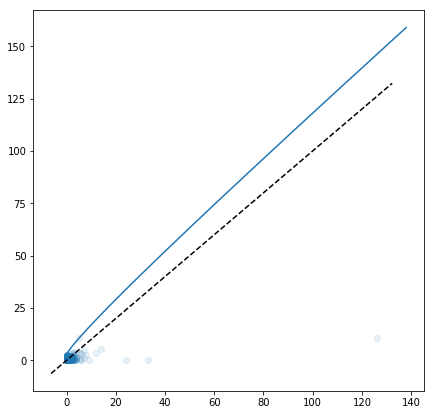

In [315]:
plt.figure(figsize=(7, 7))
plt.scatter(fam_genome_obs, fam_genome_exp, alpha=0.1)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')

#_, upper = scipy.stats.poisson.interval(0.95, range(0, int(plt.xlim()[1])))
upper = [0.5*scipy.stats.chi2.ppf(0.95, (2*k) + 2) for k in range(0, int(plt.xlim()[1]))]
plt.plot(range(0, int(plt.xlim()[1])), upper)

plt.show()

In [287]:
print([fam_genome_nm[i] for i in sorted(range(len(fam_genome_nm)), key=lambda i: np.abs(fam_genome_obs[i]-fam_genome_exp[i]), reverse=True)])
      
      

[(0, 0, 3, 0, 0, 0), (2, 1, 1, 2, 2, 2), (0, 1, 1, 0, 0, 0), (1, 1, 1, 2, 2, 2), (0, 0, 0, 1, 1, 0), (0, 0, 0, 0, 0, 1), (2, 2, 2, 1, 1, 2), (3, 3, 3, 3, 3, 0), (3, 3, 0, 0, 0, 0), (3, 0, 0, 0, 0, 0), (2, 2, 2, 2, 2, 1), (2, 3, 1, 1, 1, 1), (3, 3, 0, 3, 3, 0), (1, 1, 1, 0, 0, 0), (3, 2, 1, 1, 1, 1), (3, 3, 3, 0, 0, 3), (3, 3, 3, 0, 0, 0), (3, 3, 0, 3, 3, 3), (2, 0, 0, 1, 1, 0), (1, 0, 2, 0, 0, 0), (2, 1, 0, 0, 0, 0), (0, 1, 0, 2, 2, 0), (0, 0, 1, 0, 0, 1), (3, 1, 0, 1, 1, 0), (0, 2, 0, 1, 1, 1), (0, 2, 1, 1, 1, 2), (0, 2, 2, 2, 2, 2), (2, 0, 1, 0, 1, 1), (2, 0, 1, 1, 0, 1), (0, 2, 1, 0, 1, 1), (0, 2, 1, 1, 0, 1), (3, 0, 1, 1, 1, 1), (2, 0, 1, 1, 1, 2), (0, 1, 0, 1, 3, 0), (0, 1, 0, 3, 1, 0), (0, 3, 0, 1, 1, 0), (2, 0, 2, 2, 2, 2), (1, 0, 1, 1, 3, 0), (1, 0, 1, 3, 1, 0), (0, 3, 1, 0, 0, 1), (0, 0, 0, 0, 1, 0), (0, 0, 0, 1, 0, 0), (0, 2, 2, 1, 1, 1), (1, 3, 1, 1, 1, 1), (0, 0, 1, 0, 0, 0), (1, 0, 1, 1, 3, 1), (1, 0, 1, 3, 1, 1), (2, 2, 3, 2, 2, 2), (3, 3, 3, 3, 3, 2), (3, 3, 0, 0, 0, 3),

In [288]:
baseline = np.ones((7,))
for e, c in zip(errors, fam_genome_n):
    print(e, -np.log10(c))
    baseline[e[0]] -= c

for i, b in enumerate(baseline):
    print(i, -np.log10(b))

(0, 1) 9.0869683592
(0, 2) 9.71271098128
(0, 3) 8.09865474083
(1, 0) 3.57385652629
(1, 2) 3.71514106796
(1, 3) 3.46579804379
(2, 0) 4.15555780015
(2, 1) 4.14327158505
(2, 3) 4.50612920355
(4, 1) 8.10729552522
(4, 2) 11.3128795524
(4, 3) 9.14374984101
(5, 0) 4.51119068897
(5, 1) 3.86681634041
(5, 3) 4.23574099372
(6, 0) 6.38741598174
(6, 1) 11.1364705651
(6, 2) 11.0787763577
0 3.90006044897e-09
1 0.000348271097372
2 7.51281126664e-05
3 -0.0
4 3.70628405024e-09
5 9.76482943858e-05
6 1.779856535e-07


In [318]:
prob_status, famsum_genome_n, famsum_genome_exp, famsum_genome_obs = estimate_family_error(famsum_genome_X, famsum_genome_y)



optimal


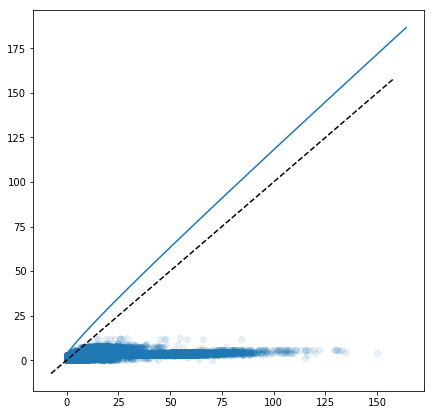

In [319]:
plt.figure(figsize=(7, 7))
plt.scatter(famsum_genome_obs, famsum_genome_exp, alpha=0.1)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')


upper = [0.5*scipy.stats.chi2.ppf(0.95, (2*k) + 2) for k in range(0, int(plt.xlim()[1]))]
plt.plot(range(0, int(plt.xlim()[1])), upper)

plt.show()

In [295]:
print(famsum_genome_n)

[  1.11499837e-09   2.45489863e-10   8.14899272e-05   1.35917381e-04
   1.25179004e-04   7.88363285e-05   4.30163332e-05   9.91687336e-05
   1.37879777e-04   9.14403345e-03   1.74638677e-02   1.42462089e-02]


In [320]:
baseline = np.ones((7,))
for e, c in zip(errors, famsum_genome_n):
    print(e, -np.log10(c))
    baseline[e[0]] -= c

for i, b in enumerate(baseline):
    print(i, -np.log10(b))

(0, 1) 5.07316736173
(0, 2) 5.29667588066
(0, 3) 5.07317007772
(1, 0) 3.72880026202
(1, 2) 4.02184198405
(1, 3) 3.95714463363
(2, 0) 4.83039935942
(2, 1) 3.97998073547
(2, 3) 4.27709065989
0 9.53260411303e-06
1 0.000170359360785
2 7.48477588718e-05
3 -0.0
4 -0.0
5 -0.0
6 -0.0


In [326]:
outliers = set()
for j in range(len(chroms)):
    family_errors = np.array([np.sum(chrom_ys[j][i]) for i in range(len(famkeys))])
    median = np.median(family_errors)
    med_abs_deviation = np.median(np.abs(family_errors-median))
    
    outlier_indices = family_errors > median+(5*med_abs_deviation)/0.6745
    outliers.update(np.where(outlier_indices)[0])
    print('chrom %s outliers %d' % (chroms[j], np.sum(outlier_indices)))
print('Total outliers', len(outliers))


chrom 1 outliers 8
chrom 2 outliers 10
chrom 3 outliers 15
chrom 4 outliers 12
chrom 5 outliers 9
chrom 6 outliers 21
chrom 7 outliers 9
chrom 8 outliers 9
chrom 9 outliers 9
chrom 10 outliers 8
chrom 11 outliers 8
chrom 12 outliers 18
chrom 13 outliers 8
chrom 14 outliers 9
chrom 15 outliers 11
chrom 16 outliers 14
chrom 17 outliers 12
chrom 18 outliers 11
chrom 19 outliers 9
chrom 20 outliers 8
chrom 21 outliers 9
chrom 22 outliers 12
chrom X outliers 19
chrom Y outliers 31
Total outliers 95


# Now separately estimate deletion error

In [116]:
family_errors = np.array([np.sum(chrom_ys[22][i]) for i in range(len(famkeys))])
median = np.median(family_errors)
med_abs_deviation = np.median(np.abs(family_errors-median))
print('Removing %d outliers' % np.sum(family_errors > median+(5*med_abs_deviation)/0.6745))

famsum_sex_X, famsum_sex_y = [], []
# append Xchrom
for i in np.where(family_errors <= median+(5*med_abs_deviation)/0.6745)[0]:
    famsum_sex_X.append(chrom_Xs[22][i])
    famsum_sex_y.append(chrom_ys[22][i])
    family_X_errors.append(np.sum(chrom_ys[22][i]))
    
family_errors = np.array([np.sum(chrom_ys[23][i]) for i in range(len(famkeys))])
median = np.median(family_errors)
med_abs_deviation = np.median(np.abs(family_errors-median))
print('Removing %d outliers' % np.sum(family_errors > median+(5*med_abs_deviation)/0.6745))

# append Ychrom
for i in np.where(family_errors <= median+(5*med_abs_deviation)/0.6745)[0]:
    famsum_sex_X.append(chrom_Xs[23][i])
    famsum_sex_y.append(chrom_ys[23][i])
    family_Y_errors.append(np.sum(chrom_ys[23][i]))
    
famsum_sex_X, famsum_sex_y = np.vstack(famsum_sex_X), np.hstack(famsum_sex_y)

print('Removing zero cols:', [errors[i] for i in np.where(np.sum(famsum_sex_X, axis=0)==0)[0]])
famsum_sex_X = famsum_sex_X[:, np.sum(famsum_sex_X, axis=0)>0]

print('Removing zero rows:', np.sum(np.sum(famsum_sex_X, axis=1)==0))
indices = np.where(np.sum(famsum_sex_X, axis=1) != 0)[0]
famsum_sex_X = famsum_sex_X[indices, :]
famsum_sex_y = famsum_sex_y[indices]
print(famsum_sex_X.shape, famsum_sex_y.shape)
    
    

Removing 19 outliers
Removing 35 outliers
Removing zero cols: []
Removing zero rows: 3770369
(123665, 18) (123665,)


In [118]:
e = famsum_genome_n.shape[0]
prob_status, famsum_sex_n, famsum_sex_exp, famsum_sex_obs = estimate_family_error(famsum_sex_X[:, e:], np.clip(famsum_sex_y - famsum_sex_X[:, :e].dot(famsum_genome_n), 0, None))



optimal


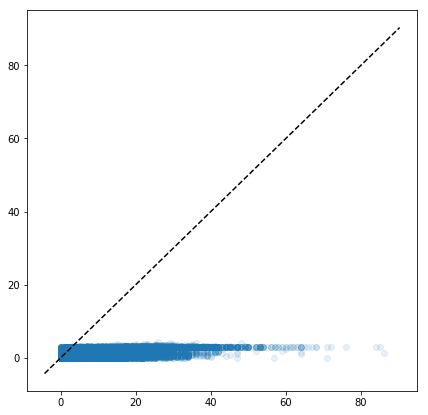

In [129]:
plt.figure(figsize=(7, 7))
plt.scatter(famsum_sex_obs, famsum_sex_exp, alpha=0.1)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.show()

In [126]:
baseline = np.ones((7,))
for e, c in zip(errors, famsum_genome_n.tolist() + famsum_sex_n.tolist()):
    print(e, -np.log10(c))
    baseline[e[0]] -= c

for i, b in enumerate(baseline):
    print(i, -np.log10(b))

(0, 1) 8.69312837743
(0, 2) 9.3156729837
(0, 3) 8.17396343447
(1, 0) 3.92569390648
(1, 2) 3.9136790134
(1, 3) 3.97204504297
(2, 0) 4.9272327991
(2, 1) 4.17096773375
(2, 3) 4.20827377052
(4, 1) 8.00252637045
(4, 2) 7.92111150766
(4, 3) 7.81694432466
(5, 0) 3.9698019963
(5, 1) 2.83947808564
(5, 3) 3.30662455158
(6, 0) 6.93202464389
(6, 1) 7.56142576997
(6, 2) 7.25701357057
0 3.99981578682e-09
1 0.000150855853311
2 6.13210473033e-05
3 -0.0
4 1.6145502284e-08
5 0.000890337990409
6 8.67410375172e-08


# Evaluate relationship between famsize and error estimates

Differences may be due to the fact that its difficult to differentiate correlated errors (for example in hard-to-sequence regions) from uncorrelated errors in small families. In large families, its much more clear.

In [723]:
famsize_Xs, famsize_Ys = [], []
for i in range(3, 11):
    fsX = np.vstack([X for X, fk in zip(Xs, famkeys) if len(family_to_inds[fk])==i])
    fsy = np.hstack([y for y, fk in zip(ys, famkeys) if len(family_to_inds[fk])==i])

    famsize_Xs.append(fsX)
    famsize_Ys.append(fsy)

In [724]:
famsize_ns = []
famsize_exps = []
famsize_obs = []
for X, y in zip(famsize_Xs, famsize_Ys):
    try:
        prob_status, n, exp, obs = estimate_family_error(X, y)
        famsize_ns.append(n)
        famsize_exps.append(exp)
        famsize_obs.append(obs)
    except:
        famsize_ns.append(None)
        famsize_exps.append(None)
        famsize_obs.append(None)

optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal


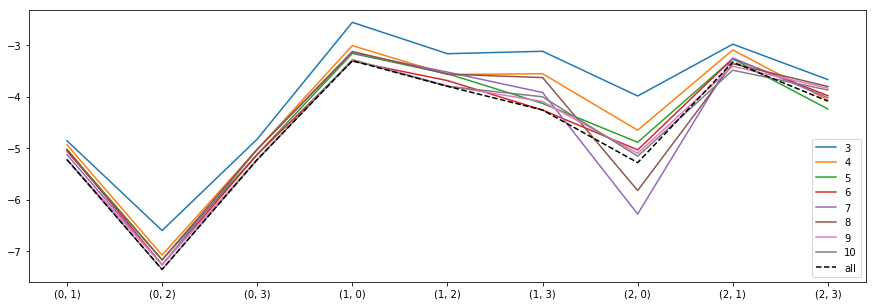

In [725]:
plt.figure(figsize=(15, 5))

for fsn, l in zip(famsize_ns, range(3, 11)):
    plt.plot(np.log10(fsn), label=str(l))

plt.plot(np.log10(n_all), color='black', label='all', linestyle='--')

plt.xticks(range(len(errors)), [str(e) for e in errors])
plt.legend()
plt.show()

# Estimate double deletion rate

In [157]:
mendelian_trios_Y_F = {
    (3, 0, 3), 
    (3, 2, 3)
}
mendelian_trios_Y_M = {
    (3, 0, 0), 
    (3, 2, 2),
}
mendelian_Y_F_check = lambda x: x in mendelian_trios_Y_F
mendelian_Y_M_check = lambda x: x in mendelian_trios_Y_M

Y_gen_to_error = {(3, 0): (6, 0), (3, 1): (6, 1), (3, 2): (6, 2),
                  (0, 1): (4, 1), (0, 2): (4, 2), (0, 3): (4, 3),
                  (2, 0): (5, 0), (2, 1): (5, 1), (2, 3): (5, 3)}

chromY_errors = [(4, 1), (4, 2), (4, 3), 
                 (5, 0), (5, 1), (5, 3), 
                 (6, 0), (6, 1), (6, 2)]

In [158]:
chrom = 'Y'
chromY_X, chromY_y = [], []

for famkey in famkeys:
    inds = family_to_inds[famkey]
    m = len(inds)
    
    ind_is_mendelian = [None, None] + [mendelian_Y_F_check if sample_id_to_sex[ind] == '2' else mendelian_Y_M_check if sample_id_to_sex[ind] == '1' else None for ind in inds[2:]]
    is_mendelian = get_mendelian(ind_is_mendelian)

    nonmendelian_famgens, error_to_fg_pairs = get_error_to_famgen_pairs(is_mendelian, [Y_gen_to_error]*m)
    
    counts = family_chrom_to_counts[(famkey, chrom)]
    X, y = build_family_chrom_X_and_y(counts, nonmendelian_famgens, error_to_fg_pairs)
    
    chromY_X.append(X)
    chromY_y.append(y)
    
    

Mendelian 2 Nonmendelian 4094
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 4094
Mendelian 2 Nonmendelian 4094
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 62
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 4094
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 4094
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelia

Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 4094
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 62
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Me

Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 4094
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 4094
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 4094
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 4094
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 4094
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1

Mendelian 2 Nonmendelian 65534
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 4094
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 4094
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 62
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 4094
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 4094
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 254
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 65534
Mendelian 2 Nonmendelian 1022
Mendelian 2 Nonmendelian 

In [159]:
print(chrom)
chromY_X, chromY_y = np.vstack(chromY_X), np.hstack(chromY_y)
print(chromY_X.shape, chromY_y.shape)
            
print('Removing zero cols:', [errors[i] for i in np.where(np.sum(chromY_X, axis=0)==0)[0]])
indices = np.where(np.sum(chromY_X, axis=0) > 0)[0]
chromY_X = chromY_X[:, indices]
        
print('Removing zero rows:', np.sum(np.sum(chromY_X, axis=1)==0))
indices = np.where(np.sum(chromY_X, axis=1) > 0)[0]
chromY_X = chromY_X[indices, :]
chromY_y = chromY_y[indices]
print(chromY_X.shape, chromY_y.shape)

prob_status, chromY_n, chromY_exp, chromY_obs = estimate_family_error(chromY_X, chromY_y)

Y
(2820500, 18) (2820500,)
Removing zero cols: [(0, 1), (0, 2), (0, 3), (1, 0), (1, 2), (1, 3), (2, 0), (2, 1), (2, 3)]
Removing zero rows: 2796848
(23652, 9) (23652,)
optimal


In [160]:
baselineY = np.ones((7,))
for e, c in zip(chromY_errors, chromY_n):
    print(e, -np.log10(c))
    baselineY[e[0]] -= c

for i, b in enumerate(baselineY):
    print(i, -np.log10(b))

(4, 1) 6.40523876466
(4, 2) 6.93073371644
(4, 3) 5.21466007704
(5, 0) 2.85873783399
(5, 1) 2.3341664311
(5, 3) 2.60573590143
(6, 0) 5.3296884319
(6, 1) 6.70626623954
(6, 2) 6.4052384371
0 -0.0
1 -0.0
2 -0.0
3 -0.0
4 2.8710290739e-06
5 0.00370554008009
6 2.28904643106e-06


In [143]:
mendelian_trios_X_F = {
    (0, 0, 0), 
    (0, 2, 1),
    (1, 0, 0), (1, 0, 1),
    (1, 2, 1), (1, 2, 2),
    (2, 0, 1),
    (2, 2, 2)
}
mendelian_trios_X_M = {
    (0, 0, 0), 
    (0, 2, 0),
    (1, 0, 0), (1, 0, 2),
    (1, 2, 0), (1, 2, 2),
    (2, 0, 2),
    (2, 2, 2)
}

mendelian_X_F_check = lambda x: x in mendelian_trios_X_F
mendelian_X_M_check = lambda x: x in mendelian_trios_X_M

X_gen_to_error_F = autosome_gen_to_error
X_gen_to_error_M = {(0, 1): (4, 1), (0, 2): (4, 2), (0, 3): (4, 3),
                    (2, 0): (5, 0), (2, 1): (5, 1), (2, 3): (5, 3)}

chromX_errors = [(0, 1), (0, 2), (0, 3),
                 (1, 0), (1, 2), (1, 3),
                 (2, 0), (2, 1), (2, 3),
                 (4, 1), (4, 2), (4, 3), 
                 (5, 0), (5, 1), (5, 3)]

In [144]:
chrom = 'X'
chromX_X, chromX_y = [], []

for famkey in famkeys:
    inds = family_to_inds[famkey]
    m = len(inds)
    
    ind_is_mendelian = [None, None] + [mendelian_X_F_check if sample_id_to_sex[ind] == '2' else mendelian_X_M_check if sample_id_to_sex[ind] == '1' else None for ind in inds[2:]]
    is_mendelian = get_mendelian(ind_is_mendelian)

    ind_gen_switch_to_error = [X_gen_to_error_F if sample_id_to_sex[ind] == '2' else X_gen_to_error_M if sample_id_to_sex[ind] == '1' else None for ind in inds]
    nonmendelian_famgens, error_to_fg_pairs = get_error_to_famgen_pairs(is_mendelian, ind_gen_switch_to_error)
    
    counts = family_chrom_to_counts[(famkey, chrom)]
    X, y = build_family_chrom_X_and_y(counts, nonmendelian_famgens, error_to_fg_pairs)
    
    chromX_X.append(X)
    chromX_y.append(y)
    
    

Mendelian 36 Nonmendelian 4060
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 36 Nonmendelian 4060
Mendelian 36 Nonmendelian 4060
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 8 Nonmendelian 56
Mendelian 20 Nonmendelian 1004
Mendelian 36 Nonmendelian 4060
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 36 Nonmendelian 4060
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmende

Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 36 Nonmendelian 4060
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 

Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 8 Nonmendelian 56
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 36 Nonmendelian 4060
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 36 Nonmendelian 4060
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 36 Nonmendelian 4060
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 24

Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 36 Nonmendelian 4060
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 132 Nonmendelian 65404
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 12 Nonmendelian 244
Mendelian 20 Nonmendelian 1004
Mendelian 36 Nonmendelian

In [145]:
print(chrom)
chromX_X, chromX_y = np.vstack(chromX_X), np.hstack(chromX_y)
print(chromX_X.shape, chromX_y.shape)
            
print('Removing zero cols:', [errors[i] for i in np.where(np.sum(chromX_X, axis=0)==0)[0]])
indices = np.where(np.sum(chromX_X, axis=0) > 0)[0]
chromX_X = chromX_X[:, indices]
        
print('Removing zero rows:', np.sum(np.sum(chromX_X, axis=1)==0))
indices = np.where(np.sum(chromX_X, axis=1) > 0)[0]
chromX_X = chromX_X[indices, :]
chromX_y = chromX_y[indices]
print(chromX_X.shape, chromX_y.shape)

prob_status, chromX_n, chromX_exp, chromX_obs = estimate_family_error(chromX_X, chromX_y)

X
(2805536, 18) (2805536,)
Removing zero cols: [(6, 0), (6, 1), (6, 2)]
Removing zero rows: 2694910
(110626, 15) (110626,)
optimal


In [147]:
baselineX = np.ones((7,))
for e, c in zip(chromX_errors, chromX_n):
    print(e, -np.log10(c))
    baselineX[e[0]] -= c

for i, (b, c) in enumerate(zip(baselineX, baseline)):
    print(i, -np.log10(b), -np.log10(c))

(0, 1) 5.32745474724
(0, 2) 7.85187919353
(0, 3) 5.73307935205
(1, 0) 3.30501947536
(1, 2) 3.90917897197
(1, 3) 4.05185980701
(2, 0) 4.49869734986
(2, 1) 3.38569653433
(2, 3) 4.06667878756
(4, 1) 5.17059885203
(4, 2) 7.70157122754
(4, 3) 5.36319529588
(5, 0) 4.32595673102
(5, 1) 3.04248237219
(5, 3) 3.52391982127
0 2.8523857837e-06 -0.0
1 0.000307342493104 -0.0
2 0.000229768711405 -0.0
3 -0.0 -0.0
4 4.82267329096e-06 0.00132059853866
5 0.000544645033066 0.00370544498786
6 -0.0 0.00229002052642


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


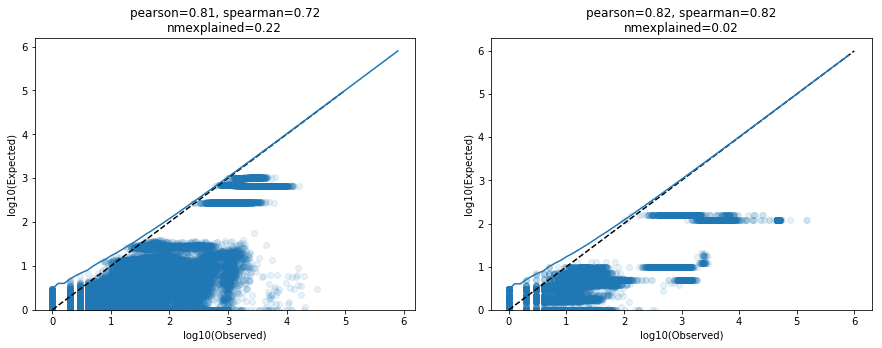

In [161]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
obs, exp = chromX_obs, chromX_exp

indices = obs != 0
pearsonr = stats.pearsonr(np.log10(obs[indices]), np.clip(np.log10(exp[indices]), 0, None))[0]
spearmanr = stats.spearmanr(np.log10(obs[indices]), np.clip(np.log10(exp[indices]), 0, None))[0]
explained = np.sum(np.clip(exp, 0, obs))/np.sum(obs)
plt.title('pearson=%0.2f, spearman=%0.2f\nnmexplained=%0.2f' % (pearsonr, spearmanr, explained))

plt.scatter(np.log10(obs[indices]), np.clip(np.log10(exp[indices]), 0, None), alpha=0.1)

max_value = np.ceil(np.max(np.log10(obs)))
plt.plot([0, max_value], [0, max_value], linestyle='--', color='black')
intervals = np.arange(0, 6, 0.1)
_, upper = scipy.stats.poisson.interval(0.95, [pow(10, i) for i in intervals])
plt.plot(intervals, np.log10(upper))
        
plt.xlabel('log10(Observed)')
plt.ylabel('log10(Expected)')
plt.ylim([0, None])

plt.subplot(1, 2, 2)
obs, exp = chromY_obs, chromY_exp

indices = obs != 0
pearsonr = stats.pearsonr(np.log10(obs[indices]), np.clip(np.log10(exp[indices]), 0, None))[0]
spearmanr = stats.spearmanr(np.log10(obs[indices]), np.clip(np.log10(exp[indices]), 0, None))[0]
explained = np.sum(np.clip(exp, 0, obs))/np.sum(obs)
plt.title('pearson=%0.2f, spearman=%0.2f\nnmexplained=%0.2f' % (pearsonr, spearmanr, explained))

plt.scatter(np.log10(obs[indices]), np.clip(np.log10(exp[indices]), 0, None), alpha=0.1)

max_value = np.ceil(np.max(np.log10(obs)))
plt.plot([0, max_value], [0, max_value], linestyle='--', color='black')
intervals = np.arange(0, 6, 0.1)
_, upper = scipy.stats.poisson.interval(0.95, [pow(10, i) for i in intervals])
plt.plot(intervals, np.log10(upper))
        
plt.xlabel('log10(Observed)')
plt.ylabel('log10(Expected)')
plt.ylim([0, None])

plt.show()

In [454]:
chrom = 'Y'
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])
print(gen_files)

# pull snp positions
pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
snp_positions = pos_data[:, 1]
is_snp = pos_data[:, 2].astype(bool)

# Pull data together
A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])

# filter out snps
A = A[:, is_snp].A
snp_positions = snp_positions[is_snp]
num_callsY = snp_positions.shape[0]

# don't need low coverage flag on missing values
A[A<0] = -1

# remove positions where whole family is missing or whole family is homref
#ok_indices = np.any(A>0, axis=0)
#A = A[:, ok_indices]
#snp_positions = snp_positions[ok_indices]

print(A.shape)
genY = A
positionsY = snp_positions

['chr.Y.gen.npz']
(4610, 231075)


In [456]:
# skip PAR
start, end = 2649520, 59034050

start_index, end_index = None, None
for i, x in enumerate(positionsY):
    if x>start:
        start_index = i
        break

for i, x in enumerate(reversed(positionsY)):
    if x < end:
        end_index = positionsY.shape[0] - 1 - i
        break
        
print(start_index, end_index, positionsY[start_index], positionsY[end_index])
genY = genY[:, start_index:(end_index+1)]
positionsY = positionsX[start_index:(end_index+1)]
num_callsY = positionsX.shape[0]

print(genY.shape)

0 231074 2649595 59034000
(4610, 231075)


In [457]:
female_indices = [sample_id in sample_id_to_sex and sample_id_to_sex[sample_id]=='2' for sample_id in sample_ids]
print(np.sum(female_indices), len(female_indices))

1514 4610


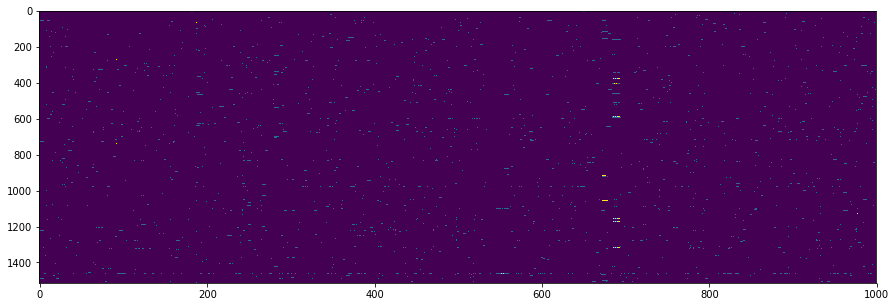

In [563]:
plt.figure(figsize=(15, 5))
indices = np.sum(genY[female_indices, :]==-1, axis=0)/np.sum(female_indices) > 0.95
plt.imshow(genY[female_indices, :][:, indices][:, :1000], aspect='auto', vmin=-1, vmax=2)
plt.show()

In [566]:
print(np.median(np.sum(genY[female_indices, :]==-1, axis=0))/np.sum(female_indices))

0.982826948481


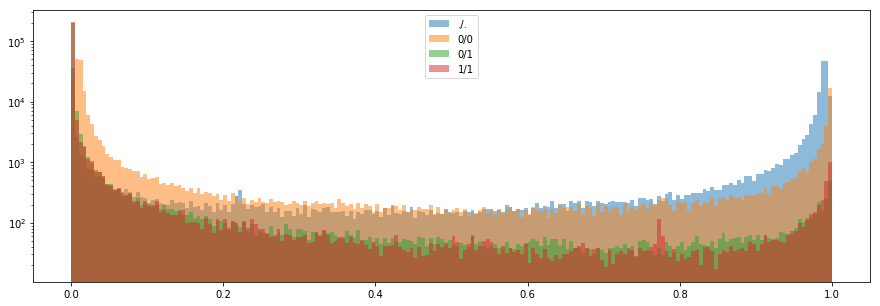

In [571]:
plt.figure(figsize=(15, 5))
plt.hist(np.sum(genY[female_indices, :]==-1, axis=0)/np.sum(female_indices), bins=np.arange(0, 1.005, 0.005), log=True, alpha=0.5, label='./.')
plt.hist(np.sum(genY[female_indices, :]==0, axis=0)/np.sum(female_indices), bins=np.arange(0, 1.005, 0.005), log=True, alpha=0.5, label='0/0')
plt.hist(np.sum(genY[female_indices, :]==1, axis=0)/np.sum(female_indices), bins=np.arange(0, 1.005, 0.005), log=True, alpha=0.5, label='0/1')
plt.hist(np.sum(genY[female_indices, :]==2, axis=0)/np.sum(female_indices), bins=np.arange(0, 1.005, 0.005), log=True, alpha=0.5, label='1/1')
#plt.hist(np.sum(genY[female_indices, :]!=-1, axis=0)/np.sum(female_indices), bins=np.arange(0, 1.005, 0.005), log=True, alpha=0.5, label='not ./.')

plt.legend()
plt.show()

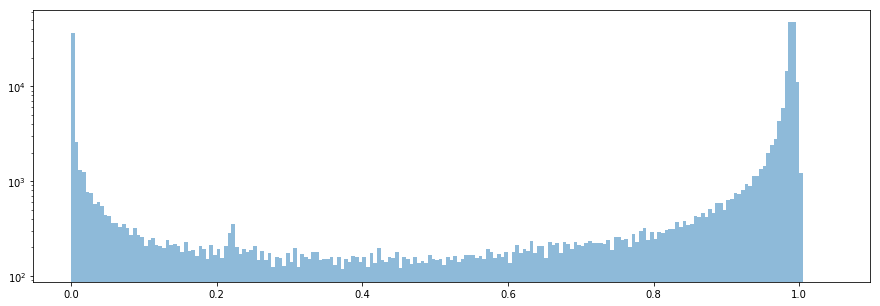

In [569]:
plt.figure(figsize=(15, 5))
plt.hist(np.sum(genY[female_indices, :]==-1, axis=0)/np.sum(female_indices), bins=np.arange(0, 1.05, 0.005), alpha=0.5, label='./.', log=True)

plt.show()


In [572]:
g, c = np.unique(genY[female_indices, :][:, indices], return_counts=True)
print(g, c)
print('-1 -> -1', c[0]/np.sum(c), -np.log10(c[0]/np.sum(c)))
print('-1 -> 0', c[1]/np.sum(c), -np.log10(c[1]/np.sum(c)))
print('-1 -> 1', c[2]/np.sum(c), -np.log10(c[2]/np.sum(c)))
print('-1 -> 2', c[3]/np.sum(c), -np.log10(c[3]/np.sum(c)))

[-1  0  1  2] [209261662   2639220      8331    109833]
-1 -> -1 0.986994640095 0.00568520577373
-1 -> 0 0.0124480326168 1.9048992824
-1 -> 1 3.92936396856e-05 4.40567774156
-1 -> 2 0.000518033648732 3.28564202986


# Estimate single deletion error rate

In [474]:
mother_son_pairs = []
for fkey, inds in families.items():
    for child in inds[2:]:
        if sample_id_to_sex[child] == '1':
            mother_son_pairs.append((inds[0], child))

print(len(mother_son_pairs))

1640


In [479]:
chrom = 'X'
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])
print(gen_files)

# pull snp positions
pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
snp_positions = pos_data[:, 1]
is_snp = pos_data[:, 2].astype(bool)

# Pull data together
A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])

# filter out snps
A = A[:, is_snp].A
snp_positions = snp_positions[is_snp]
num_callsX = snp_positions.shape[0]

# don't need low coverage flag on missing values
A[A<0] = 3

# remove positions where whole family is missing or whole family is homref
#ok_indices = np.any(A>0, axis=0)
#A = A[:, ok_indices]
#snp_positions = snp_positions[ok_indices]

print(A.shape)
genX = A
positionsX = snp_positions

['chr.X.0.gen.npz', 'chr.X.1.gen.npz']
(4610, 2965581)


In [480]:
print(genX.shape)

(4610, 2965581)


In [481]:
# skip PAR

start, end = 2699520, 154931044
start_index, end_index = None, None
for i, x in enumerate(positionsX):
    if x>start:
        start_index = i
        break

for i, x in enumerate(reversed(positionsX)):
    if x < end:
        end_index = positionsX.shape[0] - 1 - i
        break
        
print(start_index, end_index, positionsX[start_index], positionsX[end_index])
genX = genX[:, start_index:(end_index+1)]
positionsX = positionsX[start_index:(end_index+1)]
num_callsX = positionsX.shape[0]

print(genX.shape)

95116 2955906 2699522 154930651
(4610, 2860791)


In [491]:
counts = np.zeros((4, 4), dtype=int)
#for mother, son in mother_son_pairs:
moson_to_counts = defaultdict(int)

for mother, son in mother_son_pairs:
    print(mother, son)
    
    ms_gen = genX[[mother_index, son_index], :]
    ms_gen = ms_gen[:, (ms_gen[0, :]==0) | (ms_gen[0, :]==2)]
    
    mother_index, son_index = sample_id_to_index[mother], sample_id_to_index[son]
    g, c = np.unique(ms_gen, axis=1, return_counts=True)
    for x, y in zip(g.T, c):
        moson_to_counts[tuple(x)] += y

AU001201 AU001203
AU001201 AU001204
AU002101 AU002103
AU002101 AU002105
AU002101 AU002106
AU002201 AU002204
AU002201 AU002205
AU002501 AU002503
AU002501 AU002504
AU002701 AU002703
AU002701 AU002704
AU002801 AU002803
AU002801 AU002804
AU003301 AU003303
AU003301 AU003305
AU003301 AU003306
AU003701 AU003704
AU003701 AU003704
AU003701 AU003705
AU004301 AU004304
AU004301 AU004305
AU004801 AU004803
AU004801 AU004804
AU005301 AU005303
AU005301 AU005304
AU006301 AU006305
AU008401 AU008403
AU008401 AU008404
AU008401 AU008405
AU009201 AU009203
AU009201 AU009204
AU009501 AU009503
AU009501 AU009504
AU010901 AU010904
AU010901 AU010905
AU012001 AU012003
AU012001 AU012004
AU012301 AU012304
AU012701 AU012704
AU013301 AU013304
AU013401 AU013404
AU013701 AU013703
AU013701 AU013704
AU013701 AU013706
AU014501 AU014504
AU014501 AU014505
AU014501 AU014506
AU014801 AU014803
AU014801 AU014805
AU015001 AU015003
AU015001 AU015004
AU015701 AU015703
AU016201 AU016203
AU016401 AU016403
AU016401 AU016404
AU016701 A

AU0959202 AU0959303
AU0976202 AU0976301
AU0976202 AU0976302
AU0976202 AU0976303
AU0977202 AU0977302
AU0977202 AU0977303
AU1009202 AU1009301
AU1009202 AU1009302
AU1019202 AU1019301
AU1019202 AU1019302
AU1030202 AU1030302
AU1030202 AU1030303
AU1030202 AU1030304
AU1031202 AU1031301
AU1031202 AU1031302
AU1031202 AU1031303
AU1042202 AU1042301
AU1042202 AU1042302
AU1042202 AU1042303
AU1053202 AU1053302
AU1053202 AU1053303
AU1054202 AU1054301
AU1054202 AU1054302
AU1054202 AU1054303
AU1056202 AU1056301
AU1056202 AU1056303
AU1056202 AU1056304
AU1059202 AU1059301
AU1059202 AU1059302
AU1059202 AU1059303
AU1060202 AU1060301
AU1060202 AU1060302
AU1067202 AU1067301
AU1067202 AU1067302
AU1070202 AU1070301
AU1070202 AU1070302
AU1073202 AU1073301
AU1073202 AU1073302
AU1073202 AU1073303
AU1076202 AU1076303
AU1076202 AU1076304
AU1077202 AU1077301
AU1077202 AU1077302
AU1081202 AU1081301
AU1081202 AU1081302
AU1083202 AU1083301
AU1089202 AU1089303
AU1091202 AU1091304
AU1091202 AU1091306
AU1094202 AU1094301


AU1254202 AU1254301
AU1254202 AU1254302
AU1263202 AU1263302
AU1263202 AU1263301
AU1265202 AU1265302
AU1265202 AU1265303
AU1271202 AU1271304
AU1296202 AU1296301
AU1296202 AU1296302
AU1301202 AU1301301
AU1324202 AU1324302
AU1324202 AU1324303
AU1352202 AU1352301
AU1352202 AU1352302
AU1371202 AU1371303
AU1371202 AU1371304
AU1377202 AU1377301
AU1377202 AU1377302
AU1379202 AU1379301
AU1379202 AU1379302
AU1388202 AU1388301
AU1388202 AU1388302
AU1401202 AU1401302
AU1401202 AU1401303
AU1423202 AU1423303
AU1423202 AU1423304
AU1423202 AU1423305
AU1433204 AU1433305
AU1441202 AU1441301
AU1441202 AU1441302
AU1453202 AU1453301
AU1453202 AU1453302
AU1454202 AU1454301
AU1454202 AU1454302
AU1454202 AU1454303
AU1481202 AU1481302
AU1481202 AU1481303
AU1482202 AU1482303
AU1482202 AU1482304
AU1483202 AU1483302
AU1483202 AU1483303
AU1495202 AU1495302
AU1495202 AU1495304
AU1495202 AU1495305
AU1495202 AU1495303
AU1508202 AU1508302
AU1532202 AU1532301
AU1532202 AU1532302
AU1534202 AU1534301
AU1534202 AU1534302


AU1725202 AU1725302
AU1725202 AU1725306
AU1726202 AU1726304
AU1748202 AU1748302
AU1748202 AU1748303
AU1748202 AU1748304
AU1756202 AU1756301
AU1756202 AU1756302
AU1756202 AU1756303
AU1770202 AU1770302
AU1782202 AU1782301
AU1782202 AU1782302
AU1792202 AU1792302
AU1792202 AU1792303
AU1795202 AU1795301
AU1795202 AU1795302
AU1795202 AU1795303
AU1796202 AU1796304
AU1804202 AU1804301
AU1804202 AU1804302
AU1804202 AU1804303
AU1816202 AU1816301
AU1816202 AU1816303
AU1820202 AU1820302
AU1820202 AU1820303
AU1844202 AU1844302
AU1844202 AU1844303
AU1860202 AU1860302
AU1860202 AU1860303
AU1894203 AU1894303
AU1894203 AU1894304
AU1902202 AU1902301
AU1902202 AU1902302
AU1906202 AU1906301
AU1906202 AU1906302
AU1906202 AU1906304
AU1906202 AU1906305
AU1933202 AU1933302
AU1979202 AU1979301
AU1979202 AU1979302
AU1986202 AU1986301
AU1986202 AU1986302
AU1986202 AU1986303
AU1988202 AU1988301
AU1988202 AU1988302
AU1992202 AU1992301
AU1992202 AU1992302
AU2041202 AU2041301
AU2041202 AU2041302
AU2041202 AU2041303


In [492]:
mgen = 0
print('Mother %d' % mgen)
norm_factor = np.sum([moson_to_counts[(mgen, i)] for i in range(4)])
print('0', moson_to_counts[(mgen, 0)]/norm_factor, -np.log10(moson_to_counts[(mgen, 0)]/norm_factor))
print('1', moson_to_counts[(mgen, 1)]/norm_factor, -np.log10(moson_to_counts[(mgen, 1)]/norm_factor))
print('2', moson_to_counts[(mgen, 2)]/norm_factor, -np.log10(moson_to_counts[(mgen, 2)]/norm_factor))
print('3', moson_to_counts[(mgen, 3)]/norm_factor, -np.log10(moson_to_counts[(mgen, 3)]/norm_factor))

mgen = 2
print('Mother %d' % mgen)
norm_factor = np.sum([moson_to_counts[(mgen, i)] for i in range(4)])
print('0', moson_to_counts[(mgen, 0)]/norm_factor, -np.log10(moson_to_counts[(mgen, 0)]/norm_factor))
print('1', moson_to_counts[(mgen, 1)]/norm_factor, -np.log10(moson_to_counts[(mgen, 1)]/norm_factor))
print('2', moson_to_counts[(mgen, 2)]/norm_factor, -np.log10(moson_to_counts[(mgen, 2)]/norm_factor))
print('3', moson_to_counts[(mgen, 3)]/norm_factor, -np.log10(moson_to_counts[(mgen, 3)]/norm_factor))


Mother 0
0 0.995589214063 0.0019198170636
1 0.00122548067774 2.91169353192
2 0.000104553641046 3.98066083842
3 0.00308075161788 2.51134331477
Mother 2
0 0.00255841199927 2.5920295167
1 0.00332308134557 2.47845902751
2 0.987323361243 0.00554058694139
3 0.00679514541236 2.16780124517


# Estimate crossover rate

In [102]:
# estimate probability of recombination
print('Crossovers per child', (1+1.7)*22.8)
print('Maternal crossover log10(P)', np.log10(22.8)-np.log10(sum(chrom_lengths.values())))
print('Paternal crossover log10(P)', np.log10(1.7*22.8)-np.log10(sum(chrom_lengths.values())))
print('Overall crossover log10(P)', np.log10((1+1.7)*22.8)-np.log10(sum(chrom_lengths.values())))

Crossovers per child 61.56000000000001
Maternal crossover log10(P) -8.09900216768
Paternal crossover log10(P) -7.8685532463
Overall crossover log10(P) -7.66763840352


In [209]:
print('Deletion transition', np.log10(200)-np.log10(sum(chrom_lengths.values())))
print('Hard to sequence region transition', np.log10(2000)-np.log10(sum(chrom_lengths.values())))



Deletion transition -7.15590701902
Hard to sequence region transition -6.15590701902


# Estimate emmision probabilities in hard-to-sequence regions

In [226]:
del_mendelian_trios = {
    (0, 0, 0), 
    (0, 1, 0), (0, 1, 1), (0, 1, 2),
    (0, 2, 1), (0, 2, 0), (0, 2, 2),
    (1, 0, 0), (1, 0, 1), (1, 0, 2),
    (1, 1, 0), (1, 1, 1), (1, 1, 2),
    (1, 2, 1), (1, 2, 2), (1, 2, 0),
    (2, 0, 1), (2, 0, 0), (2, 0, 2),
    (2, 1, 1), (2, 1, 2), (2, 1, 0),
    (2, 2, 2)
}
is_del_mendelian = np.ones(tuple(len(x) for x in possible_genotypes_famgen), dtype=bool)
for famgen in all_famgens:
    is_del_mend = True
    for j in range(2, m):
        if tuple([famgen[x] for x in [0, 1, j]]) not in del_mendelian_trios:
            is_del_mend = False
    is_del_mendelian[famgen] = is_del_mend
print('Del Mendelian', np.sum(is_del_mendelian))
print(is_del_mendelian.shape)


Del Mendelian 569
(4, 4, 4, 4, 4, 4)


In [229]:
two_plus_steps = []
del_nonmendelian_famgens = list(zip(*np.where(~is_del_mendelian)))
del_mendelian_famgens = list(zip(*np.where(is_del_mendelian)))
for nm in del_nonmendelian_famgens:
    has_neighbor = False
    for m in del_mendelian_famgens:
        diff = len([_ for x, y in zip(nm, m) if x!=y])
        if diff == 1:
            has_neighbor = True
    if not has_neighbor:
        two_plus_steps.append(nm)

In [230]:
print(len(two_plus_steps))

2117


In [231]:
print([x for x in two_plus_steps if 3 not in x])

[]


In [232]:
emissions = [0]*4
for nm in two_plus_steps:
    for g in nm:
        emissions[g] += genotype_to_counts_genome[nm]

In [233]:
print(np.log10(emissions/np.sum(emissions)))

[-0.41768609 -1.83750238 -1.78115939 -0.23159119]


In [237]:
print(np.log10(3))

0.47712125472


In [240]:
print('0->0', np.log10(1 - pow(10, -5.06355804022) - pow(10, -4.94146261578) - pow(10, -7.02354087895)))
print('1->1', np.log10(1 - pow(10, -4.17651249194) - pow(10, -2.98674026891,) - pow(10, -3.50427197273)))
print('2->2', np.log10(1 - pow(10, -4.15130603735) - pow(10, -5.60258127541,) - pow(10, -3.19542864628)))





0->0 -8.76251358641e-06
1->1 -0.000613107855169
2->2 -0.000308768398653


In [243]:
# in a hard to sequence region, errors are 10x more likely
a = np.asarray([[0, -1, -2], [-3, -4, -5]], dtype=float)
print(np.power(2, a))

[[ 1.       0.5      0.25   ]
 [ 0.125    0.0625   0.03125]]


# Estimate missing value rate


In [24]:
chrom = '14'
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])
print(gen_files)

# pull snp positions
pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
snp_positions = pos_data[:, 1]
is_snp = pos_data[:, 2].astype(bool)

# Pull data together
A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file)) for gen_file in gen_files])

# filter out snps
A = A[:, is_snp].A
snp_positions = snp_positions[is_snp]
num_callsX = snp_positions.shape[0]

# don't need low coverage flag on missing values
A[A==-1] = 3
A[A==-2] = 4

# remove positions where whole family is missing or whole family is homref
#ok_indices = np.any(A>0, axis=0)
#A = A[:, ok_indices]
#snp_positions = snp_positions[ok_indices]

print(A.shape)
gen14 = A
positions14 = snp_positions

['chr.14.0.gen.npz', 'chr.14.1.gen.npz']
(4610, 2344178)


In [13]:
is_female = np.asarray([False if x not in sample_id_to_sex else sample_id_to_sex[x]=='2' for x in sample_ids], dtype=bool)
is_male = np.asarray([False if x not in sample_id_to_sex else sample_id_to_sex[x]=='1' for x in sample_ids], dtype=bool)

mother_indices = [sample_id_to_index[inds[0]] for inds in families.values()]
father_indices = [sample_id_to_index[inds[1]] for inds in families.values()]
print('mothers', len(mother_indices), 'fathers', len(father_indices))

affected_male_indices = sum([[sample_id_to_index[x] for x in inds[2:] if sample_id_to_sex[x]=='1' and sample_id_to_affected[x]=='2'] for inds in families.values()], [])
affected_female_indices = sum([[sample_id_to_index[x] for x in inds[2:] if sample_id_to_sex[x]=='2' and sample_id_to_affected[x]=='2'] for inds in families.values()], [])
unaffected_male_indices = sum([[sample_id_to_index[x] for x in inds[2:] if sample_id_to_sex[x]=='1' and sample_id_to_affected[x]=='1'] for inds in families.values()], [])
unaffected_female_indices = sum([[sample_id_to_index[x] for x in inds[2:] if sample_id_to_sex[x]=='2' and sample_id_to_affected[x]=='1'] for inds in families.values()], [])
print('aff-M', len(affected_male_indices), 'aff-F', len(affected_female_indices),
     'unaff-M', len(unaffected_male_indices), 'unaff-F', len(unaffected_female_indices))


mothers 886 fathers 886
aff-M 1436 aff-F 421 unaff-M 204 unaff-F 215


In [25]:
num3s = np.sum(gen14==3, axis=1)
num4s = np.sum(gen14==4, axis=1)

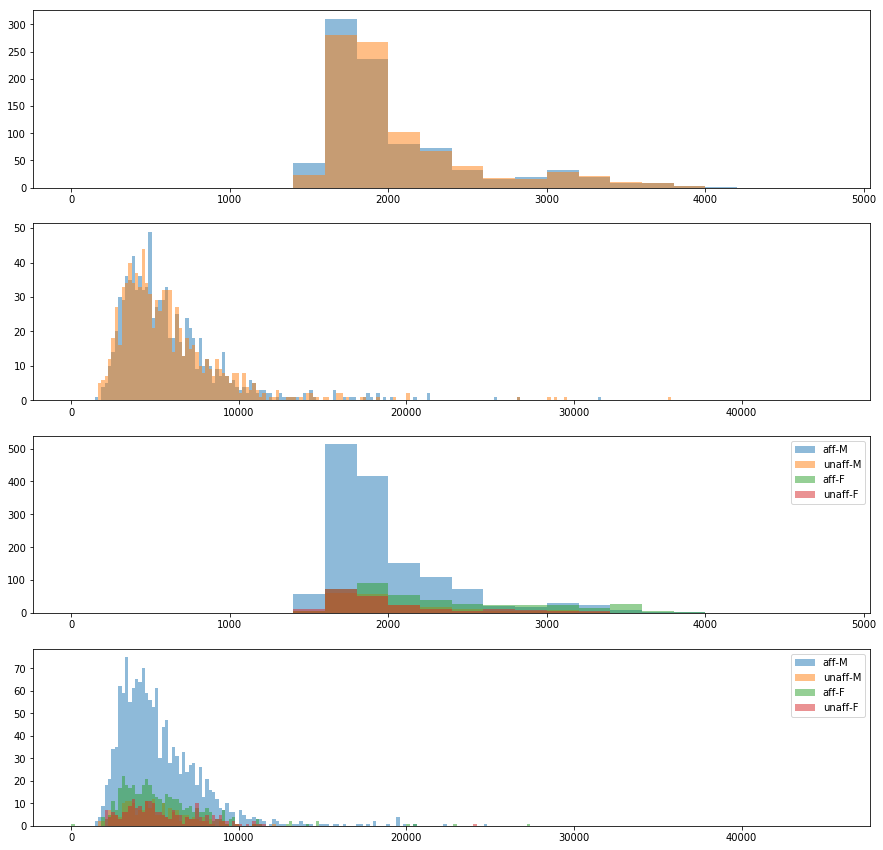

In [26]:
plt.figure(figsize=(15, 15))

min_value, max_value = min(np.min(num3s), np.min(num4s)), max(np.max(num3s), np.max(num4s))

plt.subplot(4, 1, 1)
plt.hist(num3s[mother_indices], alpha=0.5, bins=range(min_value, 5000, 200))
plt.hist(num3s[father_indices], alpha=0.5, bins=range(min_value, 5000, 200))

plt.subplot(4, 1, 2)
plt.hist(num4s[mother_indices], alpha=0.5, bins=range(min_value, max_value, 200))
plt.hist(num4s[father_indices], alpha=0.5, bins=range(min_value, max_value, 200))

plt.subplot(4, 1, 3)
plt.hist(num3s[affected_male_indices], alpha=0.5, bins=range(min_value, 5000, 200), label='aff-M')
plt.hist(num3s[unaffected_male_indices], alpha=0.5, bins=range(min_value, 5000, 200), label='unaff-M')
plt.hist(num3s[affected_female_indices], alpha=0.5, bins=range(min_value, 5000, 200), label='aff-F')
plt.hist(num3s[unaffected_female_indices], alpha=0.5, bins=range(min_value, 5000, 200), label='unaff-F')
plt.legend()

plt.subplot(4, 1, 4)
plt.hist(num4s[affected_male_indices], alpha=0.5, bins=range(min_value, max_value, 200), label='aff-M')
plt.hist(num4s[unaffected_male_indices], alpha=0.5, bins=range(min_value, max_value, 200), label='unaff-M')
plt.hist(num4s[affected_female_indices], alpha=0.5, bins=range(min_value, max_value, 200), label='aff-F')
plt.hist(num4s[unaffected_female_indices], alpha=0.5, bins=range(min_value, max_value, 200), label='unaff-F')
plt.legend()

plt.show()

In [31]:
from scipy import stats

print(stats.ttest_ind(num3s[mother_indices], num3s[father_indices], equal_var=False))
print(stats.ttest_ind(num4s[mother_indices], num4s[father_indices], equal_var=False))
print()
print(stats.ttest_ind(num3s[affected_male_indices], num3s[unaffected_male_indices], equal_var=False))
print(stats.ttest_ind(num4s[affected_male_indices], num4s[unaffected_male_indices], equal_var=False))
print()
print(stats.ttest_ind(num3s[affected_female_indices], num3s[unaffected_female_indices], equal_var=False))
print(stats.ttest_ind(num4s[affected_female_indices], num4s[unaffected_female_indices], equal_var=False))
print()
print(stats.ttest_ind(num3s[affected_female_indices+unaffected_female_indices], num3s[affected_male_indices+unaffected_male_indices], equal_var=False))
print(stats.ttest_ind(num4s[affected_female_indices+unaffected_female_indices], num4s[affected_male_indices+unaffected_male_indices], equal_var=False))
print()
print(stats.ttest_ind(num3s[affected_female_indices+affected_male_indices], num3s[unaffected_female_indices+unaffected_male_indices], equal_var=False))
print(stats.ttest_ind(num4s[affected_female_indices+affected_male_indices], num4s[unaffected_female_indices+unaffected_male_indices], equal_var=False))

print()
print('aff-M', np.median(num3s[affected_male_indices]), 'unaff-M', np.median(num3s[unaffected_male_indices]))
print('aff-F', np.median(num3s[affected_female_indices]), 'unaff-F', np.median(num3s[unaffected_female_indices]))
print()
print('aff-M', np.median(num4s[affected_male_indices]), 'unaff-M', np.median(num4s[unaffected_male_indices]))
print('aff-F', np.median(num4s[affected_female_indices]), 'unaff-F', np.median(num4s[unaffected_female_indices]))


Ttest_indResult(statistic=-0.89827744697050471, pvalue=0.36915993370520139)
Ttest_indResult(statistic=0.14291110553540098, pvalue=0.88637685831104429)

Ttest_indResult(statistic=-1.955328452264431, pvalue=0.051625497748633606)
Ttest_indResult(statistic=2.2421915351438124, pvalue=0.025618154040384797)

Ttest_indResult(statistic=6.8650845578481903, pvalue=1.8130442087825161e-11)
Ttest_indResult(statistic=-0.26584925841510182, pvalue=0.7904718196092394)

Ttest_indResult(statistic=9.5637626311970187, pvalue=1.0879153063429461e-20)
Ttest_indResult(statistic=1.7089482857598335, pvalue=0.087744744027714955)

Ttest_indResult(statistic=0.92896459968122147, pvalue=0.35324770298598418)
Ttest_indResult(statistic=0.70165602859859888, pvalue=0.48312473325204885)

aff-M 1843.5 unaff-M 1908.0
aff-F 2116.0 unaff-F 1861.0

aff-M 4706.0 unaff-M 4729.5
aff-F 4835.0 unaff-F 4870.0


In [23]:
from scipy import stats

print(stats.ttest_ind(num3s[mother_indices], num3s[father_indices], equal_var=False))
print(stats.ttest_ind(num4s[mother_indices], num4s[father_indices], equal_var=False))
print()
print(stats.ttest_ind(num3s[affected_male_indices], num3s[unaffected_male_indices], equal_var=False))
print(stats.ttest_ind(num4s[affected_male_indices], num4s[unaffected_male_indices], equal_var=False))
print()
print(stats.ttest_ind(num3s[affected_female_indices], num3s[unaffected_female_indices], equal_var=False))
print(stats.ttest_ind(num4s[affected_female_indices], num4s[unaffected_female_indices], equal_var=False))
print()
print(stats.ttest_ind(num3s[affected_female_indices+unaffected_female_indices], num3s[affected_male_indices+unaffected_male_indices], equal_var=False))
print(stats.ttest_ind(num4s[affected_female_indices+unaffected_female_indices], num4s[affected_male_indices+unaffected_male_indices], equal_var=False))
print()
print(stats.ttest_ind(num3s[affected_female_indices+affected_male_indices], num3s[unaffected_female_indices+unaffected_male_indices], equal_var=False))
print(stats.ttest_ind(num4s[affected_female_indices+affected_male_indices], num4s[unaffected_female_indices+unaffected_male_indices], equal_var=False))



Ttest_indResult(statistic=0.23642638301894697, pvalue=0.81312919826491892)
Ttest_indResult(statistic=0.73492738906866617, pvalue=0.46248108305408464)

Ttest_indResult(statistic=-1.904865207219206, pvalue=0.057919843946557338)
Ttest_indResult(statistic=-0.69986605364756427, pvalue=0.48463154372046391)

Ttest_indResult(statistic=6.9437339464087344, pvalue=1.0512852666684551e-11)
Ttest_indResult(statistic=-0.13916502274488166, pvalue=0.88938402168454922)

Ttest_indResult(statistic=10.268752730879319, pvalue=1.9833088057499401e-23)
Ttest_indResult(statistic=0.71876574324927622, pvalue=0.47242864458482492)

Ttest_indResult(statistic=0.78864365573673822, pvalue=0.43059944987485477)
Ttest_indResult(statistic=-0.78004821937352609, pvalue=0.43565933201123463)


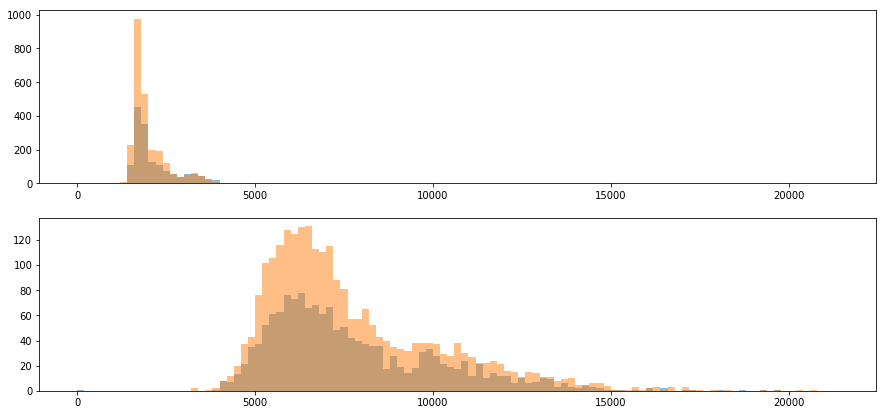

In [252]:
plt.figure(figsize=(15, 7))

min_value, max_value = min(np.min(num3s), np.min(num4s)), max(np.max(num3s), np.max(num4s))

plt.subplot(2, 1, 1)
plt.hist(num3s[is_female], alpha=0.5, bins=range(min_value, max_value, 200))
plt.hist(num3s[is_male], alpha=0.5, bins=range(min_value, max_value, 200))

plt.subplot(2, 1, 2)
plt.hist(num4s[is_female], alpha=0.5, bins=range(min_value, max_value, 200))
plt.hist(num4s[is_male], alpha=0.5, bins=range(min_value, max_value, 200))

plt.show()